In [1]:
# imports
import torch
import pickle
import os
import pyzx as zx
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import time
import datetime
import sys

In [2]:
# misc checking functions

def is_hadamard_edge(g, edge):
    return g.edge_type(edge) == zx.EdgeType.HADAMARD

def is_hadamard_edgeV(g, v1, v2):
    if g.connected(v1, v2):
        edge = g.edge(v1, v2)
        return g.edge_type(edge) == zx.EdgeType.HADAMARD
    else:
        return False

def can_fuse(g, edge):
    v1, v2 = g.edge_st(edge)
    return g.type(v1) == g.type(v2)

def get_pivot_verts(g):
    vertex_set = set()
    matches = zx.rules.match_pivot_parallel(g)
    for match in matches:
        v1, v2, _, _ = match
        vertex_set.add(v1)
        vertex_set.add(v2)

    return vertex_set

def get_fusion_verts(g):
    fusions = set()
    # loop through all EDGES in the graph
    for edge in g.edges():
        # get the vertices of the current edge
        v1, v2 = edge
        type1 = g.type(v1)
        type2 = g.type(v2) # note the types of vertex
        # make sure the edge isn't hadamard
        if g.edge_type(edge) != zx.EdgeType.HADAMARD:
            # make sure neither vertex is a boundary
            if type1 != zx.VertexType.BOUNDARY and type2 != zx.VertexType.BOUNDARY:
                # check if they can fuse (same spider type)
                if type1 == type2:
                    fusions.add(v1)
                    fusions.add(v2)

    return fusions
    
def get_lcomp_verts(g):
    matches = zx.rules.match_lcomp_parallel(g)
    vertex_set = set()

    for match in matches:
        v1, neighbors = match 
        vertex_set.add(v1)
        for vert in neighbors:
            vertex_set.add(vert)

    return list(vertex_set)

def get_bialg_verts(g):
    matches = zx.rules.match_bialg_parallel(g)
    vertex_set = set()

    for match in matches:
        v1, v2, _, _ = match
        vertex_set.add(v1)
        vertex_set.add(v2)

    return list(vertex_set)

def get_fusion_vert_pairs(g: zx.Graph):
    fusions = set()
    # loop through all EDGES in the graph
    for edge in g.edges():
        # get the vertices of the current edge
        v1, v2 = edge
        type1 = g.type(v1)
        type2 = g.type(v2) # note the types of vertex
        # make sure the edge isn't hadamard
        if g.edge_type(edge) != zx.EdgeType.HADAMARD:
            # make sure neither vertex is a boundary
            if type1 != zx.VertexType.BOUNDARY and type2 != zx.VertexType.BOUNDARY:
                # check if they can fuse (same spider type)
                if type1 == type2:
                    fusions.add((v1,v2))
    
    return fusions

In [3]:
# graph representation class
class ZXGraphRepresentation:
    def __init__(self, g: zx.Graph):
        # super(ZXGraphRepresentation, self).__init__()
        self.g = g
        self.node_features = self.get_node_features()
        self.edge_features, self.edge_index = self.get_edge_features()
        self.action_features = self.get_action_features()

    def get_node_features(self):
        node_features = []

        pivots = get_pivot_verts(self.g)
        lcomps = get_lcomp_verts(self.g)
        bialgs = get_bialg_verts(self.g)
        fusions = get_fusion_verts(self.g)

        # debugging
        # print(f"length of g.verices {len(self.g.vertices())}")
        # print(f"g.vertices {self.g.vertices}")

        length = 0
        vertices_test = self.g.vertices()
        # print(f"vertices right before looping: {vertices_test}")
        for v in self.g.vertices():
            feature_vect = [0]*9 # [node_type, degree, phase, hadamard_count, fuse_count, pivot_possible, lcomp_possible, bialg_possible, fusion_possible]
    
            # set node type 0 for Z, 1 for X, 2 for boundary
            if self.g.type(v) == zx.VertexType.Z:
                feature_vect[0] = 0
            elif self.g.type(v) == zx.VertexType.X:
                feature_vect[0] = 1
            elif self.g.type(v) == zx.VertexType.BOUNDARY:
                feature_vect[0] = 2
            else:
                feature_vect[0] = 9
    
            feature_vect[1] = len(self.g.neighbors(v))
            feature_vect[2] = self.g.phase(v)

            hadamard_count = sum(is_hadamard_edgeV(self.g, v, neighbor) for neighbor in self.g.neighbors(v))
            feature_vect[3] = hadamard_count

            fuse_count = 0
            for neighbor in self.g.neighbors(v):
                if self.g.type(v) == self.g.type(neighbor):
                    fuse_count += 1

            feature_vect[4] = fuse_count
            
            feature_vect[5] = 1 if v in pivots else 0
            feature_vect[6] = 1 if v in lcomps else 0
            feature_vect[7] = 1 if v in bialgs else 0
            feature_vect[8] = 1 if v in fusions else 0
    
            node_features.append(feature_vect)
            length+=1

        # print(f"length: {length}")
        out = torch.tensor(node_features, dtype=torch.float)
        # print(f"shape of ZXGR feature tensor: {out.shape}")
        # print(f"node feature tensor in ZXGR: {out}")
        return out

    def get_edge_features(self):
        edge_features = []
        edge_indices = []
    
        for edge in self.g.edges():
            source, target = self.g.edge_st(edge)
    
            feature_vect = [0]*2 # [Hadamard, Fuseable]
            feature_vect[0] = 1 if is_hadamard_edge(self.g, edge) else 0
            feature_vect[1] = 1 if can_fuse(self.g, edge) else 0
    
            edge_features.append(feature_vect)
            edge_indices.append([source,target])
    
        edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)
        edge_indices_tensor = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        # print(f"EDGE INDICES TENSOR: {edge_indices_tensor}")
        # print(f"EDGE FEATURES TENSOR: {edge_features_tensor}")
    
        return edge_features_tensor, edge_indices_tensor

    def get_action_features(self):
        action_features = []

        pivot_set = get_pivot_verts(self.g)
        lcomp_set = get_lcomp_verts(self.g)
        bialg_set = get_bialg_verts(self.g)
        
        for v in self.g.vertices():
            feature_vect = [0]*3 # [pivot, lcomp, bialgebra]
            feature_vect[0] = 1 if v in pivot_set else 0
            feature_vect[1] = 1 if v in lcomp_set else 0
            feature_vect[2] = 1 if v in bialg_set else 0
            
            action_features.append(feature_vect)
    
        return torch.tensor(action_features, dtype=torch.float)

    def get_graph_data(self):
        return Data(x=self.node_features, edge_index=self.edge_index)

In [4]:
# define the environment
class ZXEnv():
    def __init__(self, g: zx.Graph, num_qubits, num_gates, MAX_STEPS=100):
        self.g = g
        self.MAX_STEPS = MAX_STEPS
        self.num_qubits = num_qubits
        self.num_gates = num_gates
        self.current_step = 0
        self.done = False
        self.possible_actions = self._get_possible_actions()
        self.num_actions = len(self.possible_actions)

    def reset(self):
        # resets the environment to the initial state, which in this case will be a random zx graph
        self.current_step = 0
        self.done = False
        self.g = zx.generate.CNOT_HAD_PHASE_circuit(self.num_qubits, self.num_gates).to_graph()
        self.possible_actions = self._get_possible_actions()
        self._update_action_space()
        
        return self.g

    def _get_possible_actions(self):
        actions = []
        # put together all possible actions and matches for each step
        # pivot, lcomp, bialgebra, fusion, color change
        
        p_matches = zx.rules.match_pivot_parallel(self.g)
        for match in p_matches:
            actions += [('pivot', match)]

        lc_matches = zx.rules.match_lcomp_parallel(self.g)
        for match in lc_matches:
            actions += [('lcomp', match)]

        bialg_matches = zx.rules.match_bialg_parallel(self.g)
        for match in bialg_matches:
            actions += [('bialg', match)]

        fusion_matches = get_fusion_vert_pairs(self.g)
        for match in fusion_matches:
            actions += [('fusion', match)]

        return actions

    def step(self, action):
        past_node_count = len(self.g.vertices())
        action_type, match = action

        if action_type == 'pivot':
            zx.rules.apply_rule(self.g, zx.rules.pivot, [match])
        elif action_type == 'lcomp':
            zx.rules.apply_rule(self.g, zx.rules.lcomp, [match])
        elif action_type == 'bialg':
            zx.rules.apply_rule(self.g, zx.rules.bialg, [match])
        elif action_type == 'fusion':
            zx.rules.apply_rule(self.g, zx.rules.spider, [match])

        zx.rules.apply_rule(self.g, zx.rules.remove_ids, zx.rules.match_ids_parallel(self.g))
        
        reward = past_node_count - len(self.g.vertices())
        self.current_step += 1

        self.done = self.current_step >= self.MAX_STEPS

        return self.g, reward, self.done, {}

    def _update_action_space(self):
        self.num_actions = len(self.possible_actions)

    def render(self):
        labels = {v: f"Vertex {i}" for i, v in enumerate(self.g.vertices())}
        zx.draw(self.g, labels=labels)
        
    def close(self):
        pass        


In [5]:
zx_graph = zx.generate.CNOT_HAD_PHASE_circuit(5,25).to_graph()
test_env = ZXEnv(zx_graph,5,25)
test_env.render()
zx_rep = ZXGraphRepresentation(zx_graph)
graph_data = zx_rep.get_graph_data()
print(graph_data)

Data(x=[54, 9], edge_index=[2, 68])


In [6]:
# single gcn layer class
class GCNLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        # define a gcn convolution layer
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x is a node feature matrix, of dimensions [num_nodes, node_features]
        # edge_index is a tensor that tells the GCN which nodes are connected
        # and has dimensions [2, num_edges]

        # a first layer aggregates features from its direct neighbors
        # a second layer would be aggregating features from neighbors of neighbors
        # and so on
        
        # perform a convolution
        # print(f"Shape of x: {x.shape}")
        # print(f"x itself: {x}:")
        # print(f"Shape of edge_index: {edge_index.shape}")
        # print(f"edge_index itself: {edge_index}")
        x = self.conv(x, edge_index)
        # apply a non-linear activation function
        x = F.relu(x)
        return x

In [7]:
# gcn model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GCN, self).__init__()
        self.num_layers = num_layers

        # create list of GCN layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNLayer(input_dim, hidden_dim))
        # add middle (hidden) layers
        for _ in range(1, num_layers-1):
            self.convs.append(GCNLayer(hidden_dim, hidden_dim))
        # add final layer
        self.convs.append(GCNLayer(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index) # convolve the nodes and edges
            if i != self.num_layers - 1:
                x = F.relu(x) # activation function on the last layer

        return x

In [52]:
# test out the model
input_dim = 9 # [type, degree, phase]
hidden_dim = 16
output_dim = 4
num_layers = 2

gcn_model = GCN(input_dim, hidden_dim, output_dim, num_layers=num_layers)

zx_graph = zx.generate.CNOT_HAD_PHASE_circuit(3, 5).to_graph()
zx_rep = ZXGraphRepresentation(zx_graph)
graph_data = zx_rep.get_graph_data()

node_embeddings = gcn_model(graph_data.x, graph_data.edge_index)
print(node_embeddings)

tensor([[0.2101, 1.0425, 0.0000, 0.4272],
        [0.2101, 1.0425, 0.0000, 0.4272],
        [0.3121, 1.0349, 0.0000, 0.3090],
        [0.3775, 1.2615, 0.0000, 0.6409],
        [0.3181, 1.3964, 0.0000, 0.9590],
        [0.3318, 1.5580, 0.0000, 1.2595],
        [0.0651, 1.1853, 0.0000, 1.0523],
        [0.2036, 1.3799, 0.0000, 1.6244],
        [0.0000, 1.6866, 0.0000, 1.9584],
        [0.1352, 1.2281, 0.0000, 1.6195],
        [0.2746, 0.8048, 0.0000, 0.9728],
        [0.1632, 0.8581, 0.0000, 0.9180],
        [0.0000, 1.1038, 0.0000, 1.3232]], grad_fn=<ReluBackward0>)


In [44]:
class GCNPolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GCNPolicyNetwork, self).__init__()
        self.gcn = GCN(input_dim, hidden_dim, output_dim, num_layers)
        self.fc = torch.nn.Linear(output_dim, 4) # we want four logits (one for each possible action)

    def forward(self, graph_data):
        # print(f"Graph data: {graph_data.x}, graph_data.edge_index: {graph_data.edge_index}")
        node_embeddings = self.gcn(graph_data.x, graph_data.edge_index)
        action_logits = self.fc(node_embeddings)
        action_logits = torch.softmax(action_logits, dim=1)
        return action_logits

In [10]:
def mask_logits(logits, zx_graph_rep: ZXGraphRepresentation):
    action_features = zx_graph_rep.node_features[:, 5:9] # action features should be [pivot?, lcomp?, bialgebra?, fusion?]
    masked_logits = logits.masked_fill(action_features == 0, 0)
    return masked_logits

In [53]:
def reinforce(env, policy_net, optimizer, num_episodes, name, gamma=0.99, verbose=False, save_results=True):
    # check if the folder exists first
    if save_results:
        directory = os.path.dirname(f"results/{name}/figs/")
        os.makedirs(directory)
    
    num_qubits = env.num_qubits
    num_gates = env.num_gates

    start_time = time.time()
    
    results = []
    for episode in range(num_episodes):
        state = ZXGraphRepresentation(env.reset())

        log_probs = []
        rewards = []

        done = False
        epsilon = 1e-8
        while not done:
            action_probs = policy_net(state.get_graph_data())
            # env.render()
            # mask impossible actions
            masked_logits = mask_logits(action_probs, state)
            # here we want to flatten the tensor into 1D
            flattened_probs = torch.flatten(masked_logits)
            # then normalize all of the probabilities
            # check to see if there are no valid actions
            probsum = torch.sum(flattened_probs)
            if probsum != 0:
                normalized_probs = flattened_probs / torch.sum(flattened_probs)

                normalized_probs = torch.clamp(normalized_probs, min=0.0)  # Clamp negative values to 0
                normalized_probs[torch.isnan(normalized_probs)] = epsilon  # Replace NaNs with epsilon
                normalized_probs[torch.isinf(normalized_probs)] = epsilon  # Replace infs with epsilon
                
                # Re-normalize after the corrections to ensure valid probabilities
                normalized_probs = normalized_probs / torch.sum(normalized_probs + epsilon)
                
                action_index = torch.multinomial(normalized_probs, 1).item()
                node_index = action_index // 4
                action_type = action_index % 4 # [0: pivot, 1: lcomp, 2: bialg, 3: fusion]
    
                # map actions to action data
                action_map = {0: 'pivot', 1: 'lcomp', 2: 'bialg', 3: 'fusion'}
                valid_actions = env.possible_actions
                selected_action = None
                for action, action_data in valid_actions:
                    if action == action_map[action_type]:
                        if action == 'pivot':
                            # a pivot match is a 4-tuple
                            if node_index in action_data:
                                selected_action = (action, action_data)
                                break
                        elif action == 'lcomp':
                            # an lcomp match is (vertex, neighbors)
                            temp_vert, _ = action_data
                            if temp_vert == node_index:
                                selected_action = (action, action_data)
                                break
                        elif action == 'bialg':
                            # a bialg match is a 4-tuple (v1, v2, neighbors_of_v1,neighbors_of_v2)
                            v1, v2, _, _ = action_data
                            if v1 == node_index or v2 == node_index:
                                selected_action = (action, action_data)
                                break
                        elif action == 'fusion':
                            # a fusion match is just a tuple
                            if node_index in action_data:
                                selected_action = (action, action_data)
                                break
    
                if selected_action != None:
                    # env.render()
                    # print(f"SELECTED ACTION: {selected_action}")
                    new_g, reward, done, _ = env.step(selected_action)
                    env = ZXEnv(new_g.copy(),num_qubits,num_gates)
        
                    log_prob = torch.log(normalized_probs[action_index])
                    log_probs.append(log_prob)
                    rewards.append(reward)
        
                    state = ZXGraphRepresentation(new_g.copy())
                    #print("Updated state")
                else:
                    done = True
            else:
                done = True
                #print(f"Done with episode {episode}")

        # compute the discounted rewards
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r+gamma*R
            discounted_rewards.insert(0, R)

        discounted_rewards = torch.tensor(discounted_rewards)

        if discounted_rewards.numel() > 1:  # Ensure there are enough elements
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        else:
            # If there's only one or zero elements, just skip normalization
            discounted_rewards = discounted_rewards - discounted_rewards.mean()  # Center the rewards but no division by std
        
        
        # compute the policy loss
        policy_loss = []
        for log_prob, R in zip(log_probs, discounted_rewards):
            policy_loss.append((-log_prob * R).reshape(1))
        if len(policy_loss) != 0:
            policy_loss = torch.cat(policy_loss)
            # update the policy network
            optimizer.zero_grad()           # Clears the gradients from the previous iteration
            total_loss = policy_loss.sum()   # Sums all the individual losses
            total_loss.backward()            # Backpropagates the loss to compute gradients
            optimizer.step()                 # Updates the policy network's weights using the optimizer        

            # monitor
            total_reward = sum(rewards)
            if verbose:
                print(f"EPISODE: {episode}, TOTAL REWARD: {total_reward}, TOTAL LOSS: {total_loss.item()}")
            results.append({
                'episode': episode,
                'total_reward': total_reward,
                'total_loss': total_loss.item()
            })
        else:
            print("No actions taken. Skipping...")

        # handle outputs
        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        
        # Calculate the average time per episode
        avg_time_per_episode = elapsed_time / episode if episode > 0 else elapsed_time
        
        # Estimate remaining time
        episodes_remaining = num_episodes - episode
        estimated_time_remaining = avg_time_per_episode * episodes_remaining
        
        # Convert elapsed time and estimated remaining time to readable format
        elapsed_str = str(datetime.timedelta(seconds=int(elapsed_time)))
        remaining_str = str(datetime.timedelta(seconds=int(estimated_time_remaining)))
        
        # Print the progress on the same line
        sys.stdout.write(f"\rEpisode: {episode}/{num_episodes} | "
                         f"Elapsed time: {elapsed_str} | "
                         f"Estimated time to completion: {remaining_str}")
        
        # Flush the output to ensure it is displayed immediately
        sys.stdout.flush()
    # save results
    if save_results:
        torch.save(policy_net.state_dict(), f"results/{name}/{name}.pth")
        with open(f"results/{name}/training_progression.txt", 'w') as f:
            for entry in results:
                f.write(f"Episode: {entry['episode']}, Total Reward: {entry['total_reward']}, Total Loss: {entry['total_loss']}\n")

        print(f"\nModel saved at results/{name}.")
    print("\n")
    return results



In [54]:
# analyze the data
def create_plots(results, experiment_name, verbose=False):
    plt.ioff()
    # Extract the data
    episodes = [result['episode'] for result in results]
    total_rewards = [result['total_reward'] for result in results]
    total_losses = [result['total_loss'] for result in results]
    
    # Create a figure for plotting
    plt.figure(figsize=(12, 6))
    
    # Plot total rewards over episodes
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
    plt.plot(episodes, total_rewards, label='Total Reward', color='blue')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Total Reward over Episodes')
    plt.grid(True)
    plt.legend()
    
    # Plot total losses over episodes
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
    plt.plot(episodes, total_losses, label='Total Loss', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Total Loss')
    plt.title('Total Loss over Episodes')
    plt.grid(True)
    plt.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.savefig(f"results/{experiment_name}/figs/raw_plot.png")
    if verbose:
        plt.show()

    # smoothed plots

    # Define a simple moving average function
    def moving_average(data, window_size=10):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    
    # Apply moving average to smooth the data (window_size can be adjusted)
    smoothed_rewards = moving_average(total_rewards, window_size=10)
    smoothed_losses = moving_average(total_losses, window_size=10)
    
    # Adjust the episode range after smoothing (because the moving average reduces data points)
    smoothed_episodes = episodes[:len(smoothed_rewards)]
    
    # Plot the smoothed results
    plt.figure(figsize=(12, 6))
    
    # Smoothed rewards
    plt.subplot(1, 2, 1)
    plt.plot(smoothed_episodes, smoothed_rewards, label='Smoothed Total Reward', color='blue')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Smoothed Total Reward over Episodes')
    plt.grid(True)
    plt.legend()
    
    # Smoothed losses
    plt.subplot(1, 2, 2)
    plt.plot(smoothed_episodes, smoothed_losses, label='Smoothed Total Loss', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Total Loss')
    plt.title('Smoothed Total Loss over Episodes')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"results/{experiment_name}/figs/smoothed_plot.png")
    if verbose:
        plt.show()

    from statsmodels.nonparametric.smoothers_lowess import lowess

    # Assuming episodes, total_rewards, and total_losses are arrays
    episodes = np.array(episodes)
    rewards = np.array(total_rewards)
    losses = np.array(total_losses)
    
    # Lowess smoothing for rewards
    smoothed_rewards = lowess(rewards, episodes, frac=0.05)  # frac controls the smoothing span (0.05 = 5%)
    
    # Lowess smoothing for losses
    smoothed_losses = lowess(losses, episodes, frac=0.05)
    
    # Plotting the data with Lowess centerline
    plt.figure(figsize=(14, 8))
    
    # Plot for rewards with Lowess
    plt.subplot(2, 1, 1)
    plt.plot(episodes, rewards, label='Total Reward', color='blue', alpha=0.3)
    plt.plot(smoothed_rewards[:, 0], smoothed_rewards[:, 1], label='Lowess Centerline', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Total Reward with Lowess Centerline')
    plt.legend()
    plt.grid(True)
    
    # Plot for losses with Lowess
    plt.subplot(2, 1, 2)
    plt.plot(episodes, losses, label='Total Loss', color='orange', alpha=0.3)
    plt.plot(smoothed_losses[:, 0], smoothed_losses[:, 1], label='Lowess Centerline', color='green')
    plt.xlabel('Episodes')
    plt.ylabel('Total Loss')
    plt.title('Total Loss with Lowess Centerline')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"results/{experiment_name}/figs/lowess_centerline.png")
    if verbose:
        plt.show()


In [57]:
# set qubits and gates
num_qubits = 10 # recommended at least 3
num_gates = 30 # recommended at least 10.     In general, do more qubits and gates.
name_notes = "20k"

g = zx.generate.CNOT_HAD_PHASE_circuit(num_qubits, num_gates).to_graph()
env = ZXEnv(g, num_qubits, num_gates) # 5,20
policy_net = GCNPolicyNetwork(input_dim=9, hidden_dim=8, output_dim=4, num_layers=2)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
experiment_name = f"{name_notes}_{num_qubits}q_{num_gates}g"

results = reinforce(env, policy_net, optimizer, name=experiment_name, num_episodes=20000, gamma=.99, verbose=False, save_results=True)
if results:
    print("done.")

Episode: 19999/20000 | Elapsed time: 0:18:13 | Estimated time to completion: 0:00:00
Model saved at results/20k_10q_30g.


done.


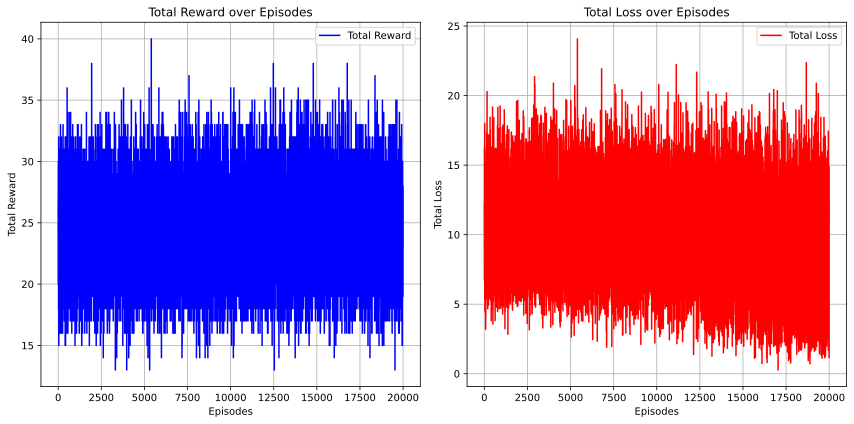

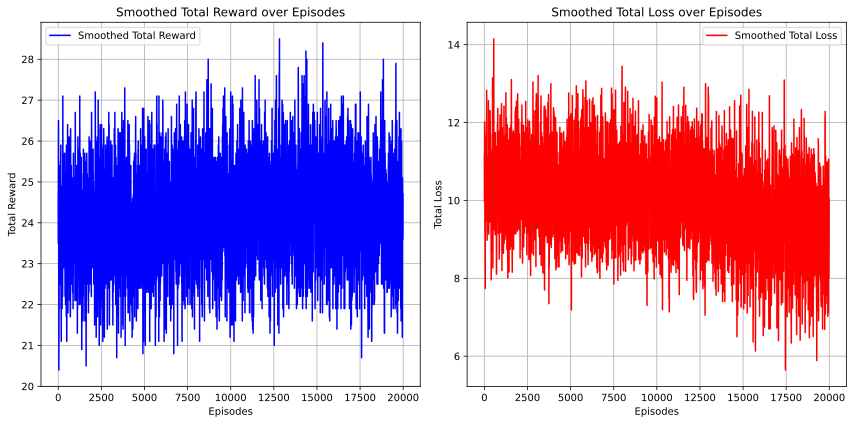

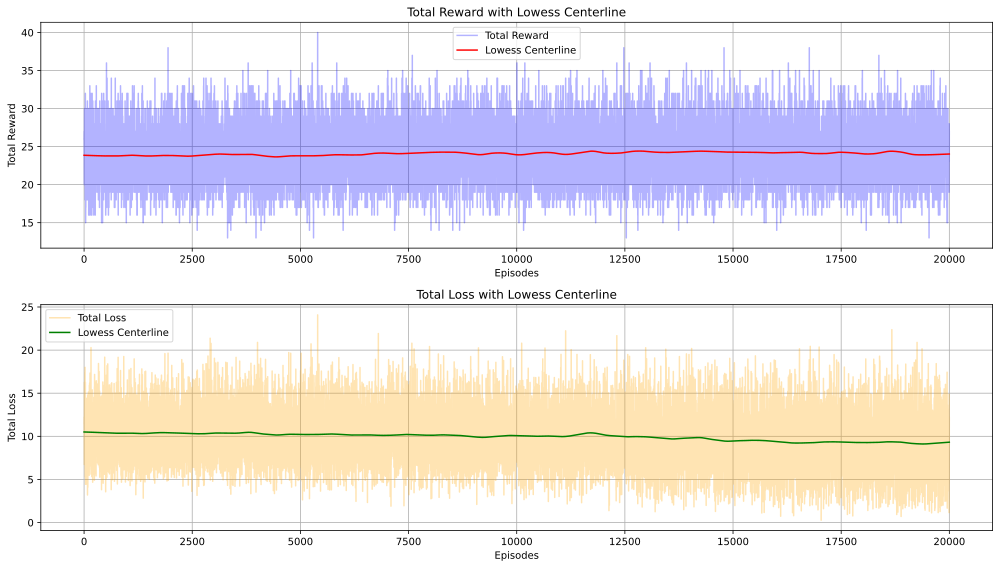

In [58]:
create_plots(results, experiment_name, verbose=True)